### Training a neural network revolves around the following concepts
- `Tensors`, including special tensors that store the network’s state (variables)
- `Tensor` operations such as addition, `relu`, `matmul`
- `Backpropagation`, a way to compute the gradient of mathematical expressions

### high-level deep learning concepts :
- `Layers`, which are combined into a model
- A `loss function`, which defines the feedback signal used for learning
- An `optimizer`, which determines how learning proceeds
- `Metrics` to evaluate model performance, such as accuracy
- A `training loop` that performs mini-batch stochastic gradient descent

#### To do anything in TensorFlow, we’re going to need some tensors.

In [1]:
### Tensorflow Tensors :
import tensorflow as tf
import numpy as np

tf.ones((3, 3))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

In [2]:
tf.random.normal((2, 2), mean=0, stddev=1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.2499223 ,  0.21505015],
       [-0.5371041 ,  0.9337656 ]], dtype=float32)>

In [3]:
tf.random.uniform((2, 2), minval=0, maxval=1)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.29503548, 0.5099766 ],
       [0.30262434, 0.85242426]], dtype=float32)>

#### A significant difference between NumPy arrays and TensorFlow tensors is that TensorFlow tensors aren’t assignable: they’re constant.

#### To train a model, we’ll need to **update** its state, which is a set of tensors. If tensors aren’t assignable, how do we do it? That’s where variables come in. `tf.Variable` is the class meant to manage modifiable state in TensorFlow.

#### The state of a variable can be modified via its method,`assign`

In [4]:
v = tf.Variable(initial_value=tf.random.uniform((3, 1), minval=0, maxval=1))
v

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.72714794],
       [0.92349243],
       [0.750327  ]], dtype=float32)>

In [5]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [6]:
v[0, 0].assign(4)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [1.],
       [1.]], dtype=float32)>

#### `assign_add()` and `assign_sub()` are efficient equivalents of `+=` and `-=`

In [7]:
v

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [1.],
       [1.]], dtype=float32)>

In [8]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[5.],
       [2.],
       [2.]], dtype=float32)>

#### TensorFlow seems to look a lot like NumPy. But here’s something NumPy can’t do: `retrieve the gradient of any differentiable expression` with respect to any of its inputs.

- #### Open a `GradientTape` scope
- #### apply some computation to one or several input tensors
- #### retrieve the gradient of the result with respect to the inputs.

In [9]:
### Using the GradientTape
input_var = tf.Variable(initial_value=4.)
with tf.GradientTape() as tape:
    result = tf.square(input_var)
grad = tape.gradient(result, input_var)

In [10]:
grad

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

### This is most commonly used to retrieve the gradients of the loss of a model with respect to its weights:  gradients = tape.gradient(loss,weights).

#### Only trainable variables are tracked by default. With a `constant tensor`, you’d have to manually mark it as being tracked by calling `tape.watch()` on it.

In [11]:
input_constant = tf.constant(4.)
with tf.GradientTape() as tape:
    tape.watch(input_constant)
    result_c = tf.square(input_constant)

grad_c = tape.gradient(result_c, input_constant)

In [12]:
grad_c

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

#### To avoid wasting resources, the tape needs to know what to watch. `Trainable variables` are watched by default because computing the gradient of a loss with regard to a list of trainable variables is the most common use of the gradient tape.


#### Gradient tape is even capable of computing second-order gradients, that is to say, the `gradient of a gradient`.

##### For instance, the gradient of the `position of an object with regard to time` is the `speed` of that object, and the `second-order gradient` is its `acceleration`.

#### Example :
##### If you measure the position of a falling apple along a vertical axis over time and find that it verifies position(time) = 4.9 * time ** 2, what is its acceleration?

In [13]:
time = tf.Variable(0.)

with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = 4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

In [14]:
acceleration

<tf.Tensor: shape=(), dtype=float32, numpy=9.8>

## A linear classifier in pure TensorFlow :

To build any machine learning model based on gradient
descent we need :
- Tensors
- Variables
- Tensor Operations (for Feed Forward)
- Compute The Gradients (For Backprapagation)

In [15]:
###  first Generating A Toy Dataset (1000 samples per 2 classes with normal distribution) :

num_per_class = 1000

negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_per_class
)

positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5], [0.5, 1]],
    size=num_per_class
)

# reuse the same
# covariance matrix for both point clouds, but we’ll use two different mean values—the
# point clouds will have the same shape, but different positions.

In [16]:
print("Negative Samples Shape :", negative_samples.shape)

print("Positive Samples Shape :", positive_samples.shape)

Negative Samples Shape : (1000, 2)
Positive Samples Shape : (1000, 2)


In [17]:
# stack data to build one dataset
data = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [18]:
data.shape

(2000, 2)

In [19]:
### Generating Corresponding Targets
targets = np.vstack(
    (np.zeros((num_per_class, 1), dtype="float32"),
     np.ones((num_per_class, 1), dtype="float32"))
)

In [20]:
targets.shape

(2000, 1)

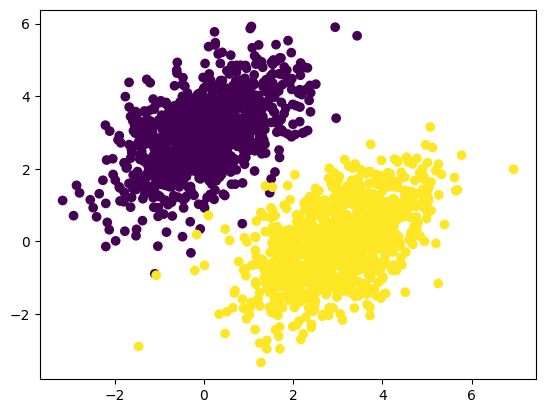

In [21]:
### Plotting Data:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=targets)

In [22]:
# let’s create a linear classifier that can learn to separate these two blobs. A linear
# classifier is an affine transformation (prediction = W • input + b) trained to minimize
# the square of the difference between predictions and the targets.(MSE)

input_dim = 2
output_dim = 1

W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))

B = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [23]:
### Forward pass
def model(inputs):
    return tf.matmul(inputs , W) + B

In [24]:
### MSE Loss
def mse_loss(targets, predictions):
    loss_per_samples = tf.square(targets - predictions)
    return tf.reduce_mean(loss_per_samples)

In [25]:
# Training :

learning_rate = 0.1

def training_steps(inputs, targets):
    with tf.GradientTape() as tape:
        # Forwards
        predictions = model(inputs)
        # Loss :
        loss = mse_loss(targets, predictions)
    # Backpropagation
    grads_W, grads_B = tape.gradient(loss, [W, B])
    # Update weights :
    W.assign_sub(learning_rate * grads_W)
    B.assign_sub((learning_rate * grads_B))
    return loss


In [26]:
# The training loop :
epochs = 50
training_loss = []
for epoch in range(epochs+1):
    loss = training_steps(data, targets)
    training_loss.append(loss)
    print(f"Loss at epoch {epoch} : {loss:.4f}")

Loss at epoch 0 : 3.9139
Loss at epoch 1 : 0.5382
Loss at epoch 2 : 0.1891
Loss at epoch 3 : 0.1417
Loss at epoch 4 : 0.1275
Loss at epoch 5 : 0.1177
Loss at epoch 6 : 0.1091
Loss at epoch 7 : 0.1013
Loss at epoch 8 : 0.0943
Loss at epoch 9 : 0.0879
Loss at epoch 10 : 0.0821
Loss at epoch 11 : 0.0768
Loss at epoch 12 : 0.0720
Loss at epoch 13 : 0.0677
Loss at epoch 14 : 0.0637
Loss at epoch 15 : 0.0602
Loss at epoch 16 : 0.0569
Loss at epoch 17 : 0.0540
Loss at epoch 18 : 0.0513
Loss at epoch 19 : 0.0489
Loss at epoch 20 : 0.0467
Loss at epoch 21 : 0.0447
Loss at epoch 22 : 0.0428
Loss at epoch 23 : 0.0412
Loss at epoch 24 : 0.0397
Loss at epoch 25 : 0.0383
Loss at epoch 26 : 0.0371
Loss at epoch 27 : 0.0360
Loss at epoch 28 : 0.0350
Loss at epoch 29 : 0.0340
Loss at epoch 30 : 0.0332
Loss at epoch 31 : 0.0324
Loss at epoch 32 : 0.0318
Loss at epoch 33 : 0.0311
Loss at epoch 34 : 0.0306
Loss at epoch 35 : 0.0300
Loss at epoch 36 : 0.0296
Loss at epoch 37 : 0.0292
Loss at epoch 38 : 0.0

Text(0, 0.5, 'Loss')

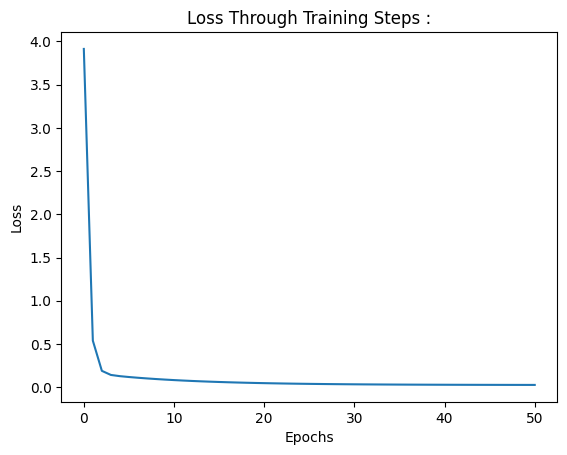

In [27]:
plt.plot(training_loss)
plt.title('Loss Through Training Steps :')
plt.xlabel('Epochs')
plt.ylabel('Loss')

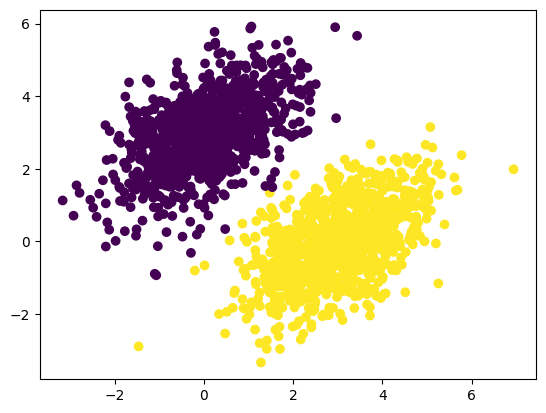

In [29]:
### Plot Predictions Data
predictions = model(data)
plt.scatter(data[:,0], data[:, 1], c=predictions > 0.5) # Threshold on Predictions

# Because our targets are zeros and
# ones, a given input point will be classified as “0” if its prediction value is below 0.5, and
# as “1” if it is above 0.5

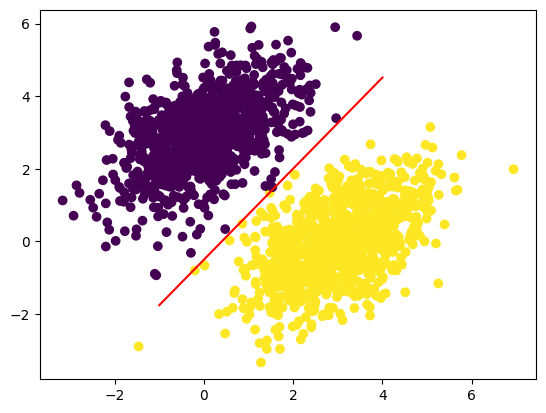

In [30]:
### Plot Equation Line :
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (0.5 - B) / W[1] ##  ?
plt.plot(x, y, "-r")
plt.scatter(data[:, 0], data[:, 1], c=predictions > 0.5)